In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.special import erfc

In [4]:
def initial_condition_I(L=None, dx=None, N=None):
    """
    Generate initial state, containing all zeros except for the top
    """ 
    if N is None:
        N = round(L / dx)
    state = np.zeros((N, N))
    state[-1] = 1.
    return state

In [5]:
def final_difference_method(state, next_state, i, j, N, dt=0, D=0, dx=0, omega=0):
    """
    Calculate state of discretized point according to finite difference method based on neighboring points in the previous state
    """
    top = state[i - 1, j]
    bottom = state[i + 1, j]
    left = state[i, j - 1]

    # Connect edged
    right = state[i, (j + 1) % (N - 1)]
    center = state[i, j]
    return center + dt * D / dx**2 * (left + right + top + bottom - 4 * center)

In [6]:
def jacobi_iteration(state, next_state, i, j, N, dt=0, D=0, dx=0, omega=0):
    """
    Calculate state of discretized point according to Jacobi iteration based on neighboring points in the previous state
    """ 
    top = state[i - 1, j]
    bottom = state[i + 1, j]
    left = state[i, j - 1]

    # Connect edges
    right = state[i, (j + 1) % (N - 1)]
    return (left + right + top + bottom) / 4

In [7]:
def gauss_seidel_iteration(state, next_state, i, j, N, dt=0, D=0, dx=0, omega=0):
    """
    Calculate state of discretized point according to Gauss-Seidel iteration based on neighboring points in the previous state
    """ 
    top = next_state[i - 1, j]
    bottom = state[i + 1, j]

    # Connect edges, and only pick left neighbor if it is already calcuated. Otherwise pick previous state
    left = next_state[i, j - 1] if j > 0 else state[i, j]
    right = state[i, (j + 1) % (N - 1)]
    return (left + right + top + bottom) / 4

In [8]:
def successive_over_relaxation(state, next_state, i, j, N, dt=0, D=0, dx=0, omega=0):
    """
    Calculate state of discretized point according to Successive over relaxation based on neighboring points in the previous state
    """ 
    top = next_state[i - 1, j]
    bottom = state[i + 1, j]

    # Connect edges, and only pick left neighbor if it is already calcuated. Otherwise pick previous state
    left = next_state[i, j - 1] if j > 0 else state[i, j]
    right = state[i, (j + 1) % (N - 1)]
    center = state[i, j]
    return omega * (left + right + top + bottom) / 4 + (1 - omega) * center

In [9]:
def do_timestep(state, dt, dx, D, N, calculate_concentration, omega):
    """
    Do single timestep
    """ 

    # Start as initial condition
    next_state = initial_condition_I(N=N)

    # Loop over discretized points in space
    for i in range(1, N - 1):
        for j in range(N):

            # Calculate concentration based on neighbors according to provided solving method
            next_state[i, j] = calculate_concentration(state, next_state, i, j, N, dt, D, dx, omega)

    return next_state

In [10]:
def do_T_timesteps(initial_condition, D, dt, dx, N, T, store_ts, calculate_concentration, omega, epsilon, animation_frames=[]):
    """
    Do timesteps untill stopping criteria is met, which can either be a maximum point in time reached, or when the system reaches a stationary state.

    """ 

    # Calculate accuracy on discretized timesteps based on dt to prevent floating point errors
    t_decimals = round(-1 * np.log10(dt))

    # Calculate center column
    center_y = int(N / 2)

    ys = []

    # Empty array where the states for the animation are stored
    states_to_keep = np.zeros((len(animation_frames), N, N))

    if len(animation_frames) > 0:
        states_to_keep[0] = initial_condition

    # Do single timestep
    state = do_timestep(initial_condition, dt, dx, D, N, calculate_concentration, omega)
    
    # Calculate discretized timesteps
    ts = np.arange(0, T + dt, dt)

    # Iterate over timesteps
    for i, t in enumerate(ts):

        # Calculate next state based on previous state
        next_state = do_timestep(state, dt, dx, D, N, calculate_concentration, omega)

        # If state of single column along y-axis is to be saved on this timestep
        if round(t, t_decimals) in store_ts:
            ys.append(state[:,center_y])

        # If entire state is to be saved for the animation on this timestep
        if (t:=round(t, t_decimals)) in animation_frames:

            # Store current frame in proper position in the array containing frames for animation
            states_to_keep[np.where(animation_frames == t)[0]] = state

        # If we only care about the final stationary state, return results if improvement becomes insignificant
        if len(store_ts) == 0 and np.max(np.abs(state - next_state)) < epsilon:
            ys.append(state[:,center_y])
            return ys, states_to_keep, i
        
        # Set state to proper matrix for next iteration
        state = np.copy(next_state)
    
    return ys, states_to_keep, i

In [11]:
def update(frame, im):
    im.set_array(frame)
    return im,

In [12]:
def get_function_name(f):
    """
    Retrieve function name and transform it to a string usable for labeling curves in the final plots
    """ 
    return f.__name__.replace('_', ' ').capitalize()

In [59]:
def run_simulation(initial_condition, dx, L, T=100, D=0, dt=0.001, store_ts=[], filename=None, make_animation=False, line_ax=None, calculate_concentration=final_difference_method, omega=0, epsilon=1e-5, plot=True):
    """
    Run simulation, optionally make animation or various plots
    """ 

    # Calculate amount of discretized x-coordinates
    N = round(L / dx)
    animation_frames = []

    if make_animation:

        # Settings for the animation
        framerate=30
        duration=30

        # Calculate total number of frames, timesteps, and which frames to save based on framerate and duration of the animation
        frames = framerate * duration
        timesteps = round(T / dt)
        frequency = round(timesteps / frames)
        t_decimals = round(-1 * np.log10(dt))

        # Make array of timesteps to store
        animation_frames = np.around(np.arange(0, T, dt)[::frequency], t_decimals)

    # Do simulation, and extract the desired frames, and the iterations it took before the system was stationary
    ys, states_to_keep, i = do_T_timesteps(initial_condition, D, dt, dx, N, T, store_ts, calculate_concentration, omega, epsilon, animation_frames)

    if make_animation:

        fig, ax = plt.subplots()

        ax.set_xlabel('x')
        ax.set_ylabel('y')

        # Change x- and y-scales from array indices to coordinates
        extent = [0, L, 0, L]
        im = ax.imshow(states_to_keep[0], cmap='hot', extent=extent, origin='lower')
        
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Concentration')

        # Make animation based on stored frames
        ani = animation.FuncAnimation(fig, update, fargs=(im,), frames=states_to_keep, interval=1000/framerate, blit=False)

        if filename:
            ani.save(f'{filename}.gif', writer='pillow', fps=framerate)
        else:
            plt.show()
        return

    # Plot different states of the system
    elif plot:
        if not line_ax:
            line_fig, line_ax = plt.subplots()

        if len(store_ts) > 0:
            for i, y in enumerate(ys):
                line_ax.plot(np.linspace(0, L, N), y, label=store_ts[i])
        else:
            function_name = get_function_name(calculate_concentration)
            line_ax.plot(np.linspace(0, L, N), ys[-1], label=f'{function_name}, {i} iterations')
        
        line_ax.legend()

        if filename:
            plt.savefig(filename)
        else:
            plt.show()

    # If no plots are to be made, return the number of iterations it took before the system was stationary
    return i

1.0


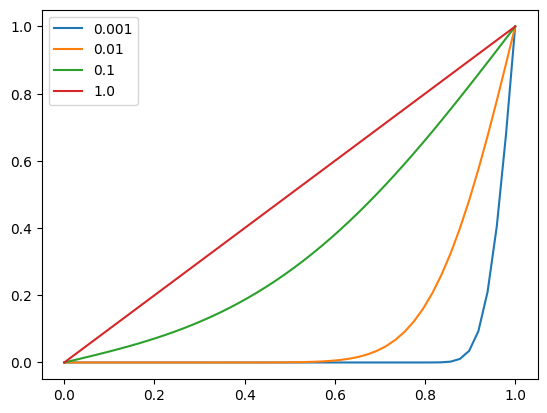

3

In [14]:
D = 1
T = 1
L = 1
dt = 0.0001
dx = 0.02

print(4 * dt * D / dx**2)
store_ts = [0.001, 0.01, 0.1, 1.]
initial_condition = initial_condition_I(L, dx)

run_simulation(initial_condition, dx, L, T, D, dt, store_ts)

In [15]:
def calculate_analytical_concentration(y_values, t, D, num_terms=10000):
    """
    Calculate concentration analytically
    """ 
    integral_sum = np.zeros_like(y_values)

    for i in range(num_terms):
        arg1 = 1 - y_values + 2*i
        arg2 = 1 + y_values + 2*i
        integral_sum += erfc(arg1 / (2 * np.sqrt(D * t))) - erfc(arg2 / (2 * np.sqrt(D * t)))
    
    return integral_sum

1.0


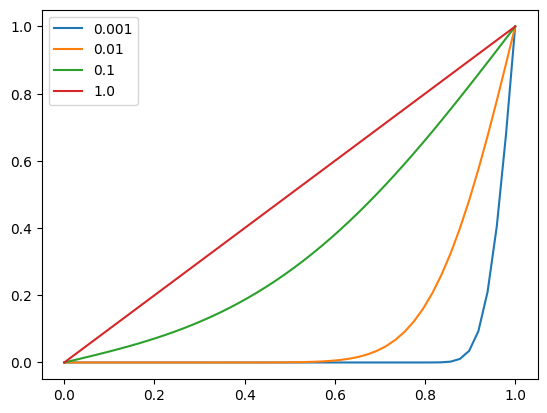

3

In [16]:
D = 1
T = 1
L = 1
dt = 0.0001
dx = 0.02
fig, ax = plt.subplots()

print(4 * dt * D / dx**2)
store_ts = [0.001, 0.01, 0.1, 1.]
initial_condition = initial_condition_I(L, dx)

run_simulation(initial_condition, dx, L, T, D, dt, store_ts, line_ax=ax)

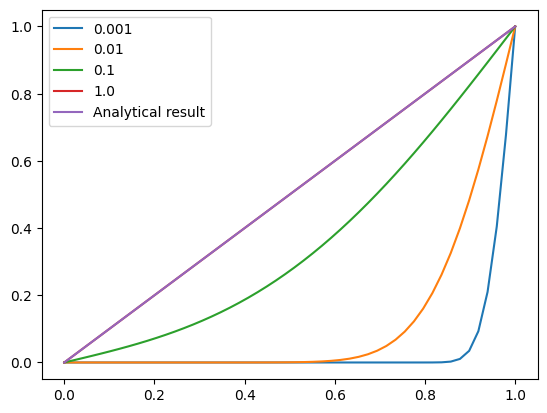

In [17]:
y_values = np.linspace(0., 1.0, 1000)

c_values = calculate_analytical_concentration(y_values, T, D)
ax.plot(y_values, c_values, label='Analytical result')
ax.legend()
fig

1.0


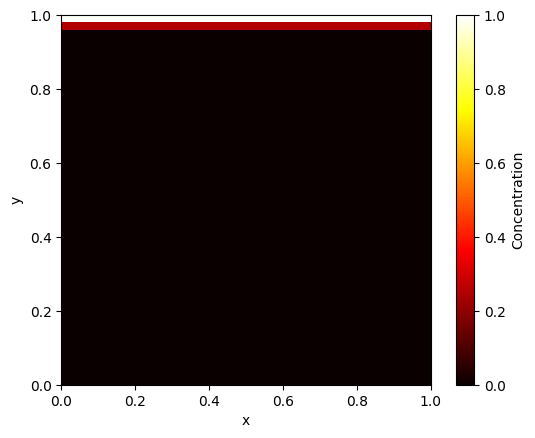

In [18]:
print(4 * dt * D / dx**2)
store_ts = [0.001, 0.01, 0.1, 1.]
initial_condition = initial_condition_I(L, dx)

run_simulation(initial_condition, dx, L, T, D, dt, store_ts, make_animation=True, filename='animation_IV')

1.0


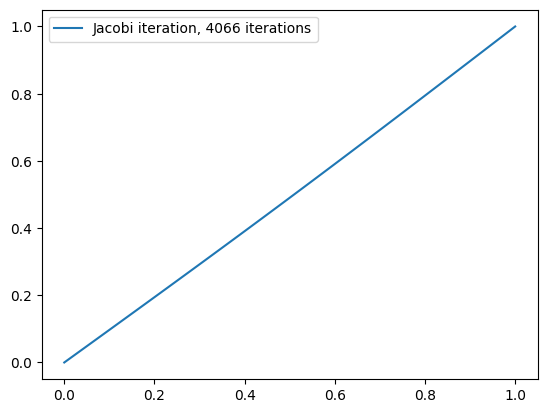

4066

In [19]:
D = 1
T = 1
L = 1
dt = 0.0001
dx = 0.02
fig, ax = plt.subplots()

print(4 * dt * D / dx**2)
initial_condition = initial_condition_I(L, dx)

run_simulation(initial_condition, dx, L, line_ax=ax, calculate_concentration=jacobi_iteration)

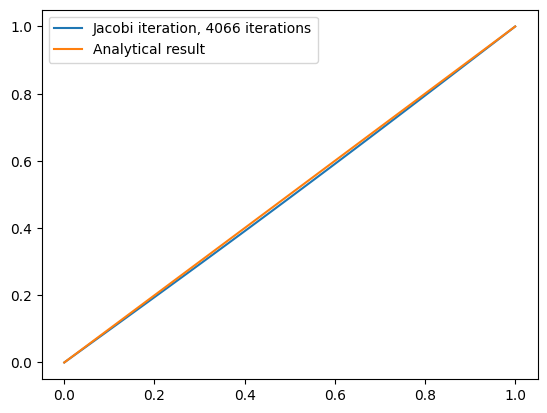

In [20]:
y_values = np.linspace(0., 1.0, 1000)
T=100

c_values = calculate_analytical_concentration(y_values, T, D)
ax.plot(y_values, c_values, label='Analytical result')
ax.legend()
fig

1.0


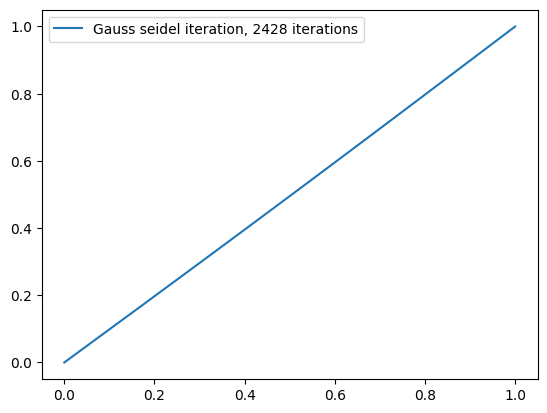

2428

In [21]:
fig, ax = plt.subplots()

print(4 * dt * D / dx**2)
initial_condition = initial_condition_I(L, dx)

run_simulation(initial_condition, dx, L, line_ax=ax, calculate_concentration=gauss_seidel_iteration)

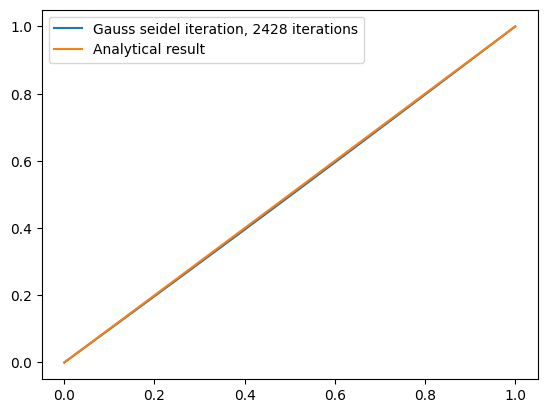

In [22]:
y_values = np.linspace(0., 1.0, 1000)
T=100

c_values = calculate_analytical_concentration(y_values, T, D)
ax.plot(y_values, c_values, label='Analytical result')
ax.legend()
fig

1.0


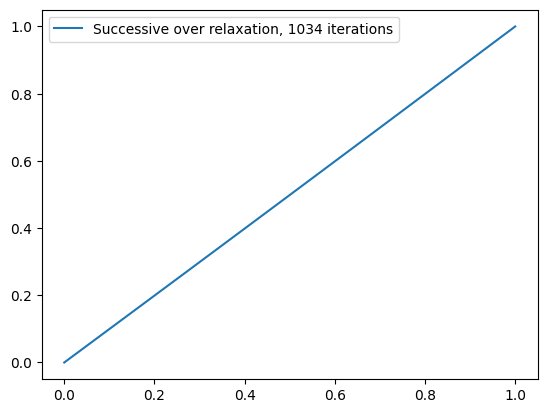

1034

In [23]:
fig, ax = plt.subplots()

print(4 * dt * D / dx**2)
initial_condition = initial_condition_I(L, dx)
omega = 1.5

run_simulation(initial_condition, dx, L, line_ax=ax, calculate_concentration=successive_over_relaxation, omega=omega)

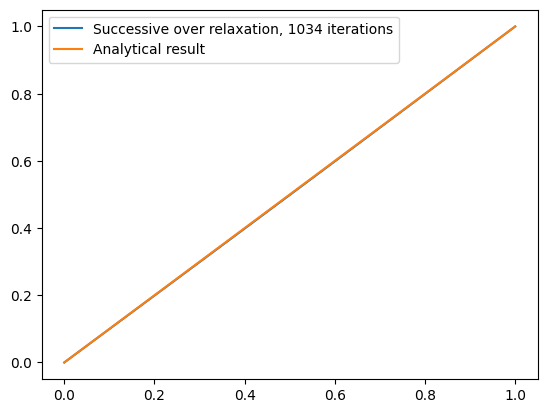

In [24]:
y_values = np.linspace(0., 1.0, 1000)
T=100

c_values = calculate_analytical_concentration(y_values, T, D)
ax.plot(y_values, c_values, label='Analytical result')
ax.legend()
fig

In [43]:
def investigate_convergence(epsilons, solvers, omegas, ax, L=1, dx=0.02):
    """
    Investigate the convergence rate of different solvers as a function of epsilon. For the succesive over relaxation method, several values for omega are used
    """

    # Iterate over solvers
    for i, solver in enumerate(solvers):

        # Extract omega and get function name to use for label while plotting
        omega=omegas[i]
        function_name = get_function_name(solver)

        # Add omega to label if it is relevant
        if function_name.strip() == 'Successive over relaxation':
            label = f'{function_name}, omega = {omega}'
        else:
            label = f'{function_name}'

        # Empty array to store results
        results = np.zeros_like(epsilons)
        
        # Iterate over epsilons, and calculate convergence
        for j, epsilon in enumerate(epsilons):
            initial_condition = initial_condition_I(L, dx)
            results[j] = run_simulation(initial_condition, dx, L, calculate_concentration=solver, omega=omega, epsilon=epsilon, plot=False)

        # Plot results
        ax.plot(epsilons, results, label=label)
    

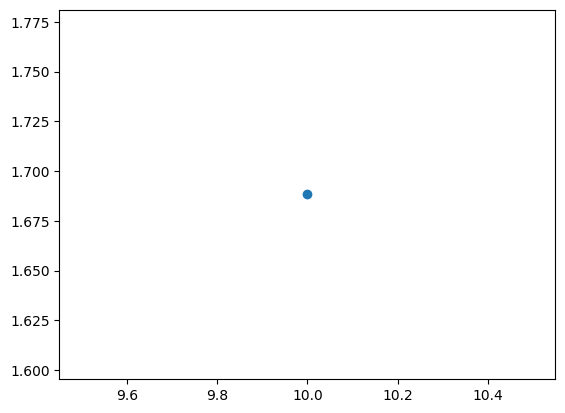

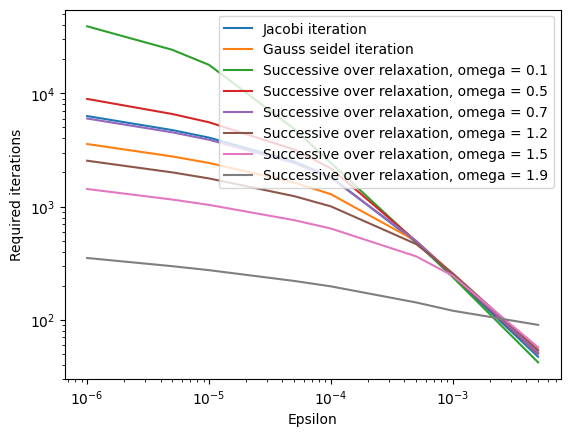

In [53]:
epsilons = np.array([1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3])
solvers = [jacobi_iteration, gauss_seidel_iteration, successive_over_relaxation, successive_over_relaxation, successive_over_relaxation, successive_over_relaxation, successive_over_relaxation, successive_over_relaxation]
omegas = [1, 1, 0.1, 0.5, 0.7, 1.2, 1.5, 1.9]

fix, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Required iterations')

investigate_convergence(epsilons, solvers, omegas, ax)
ax.legend()
fig

In [54]:
def find_optimal_omega(Ns, ax, L=1, min_=0.01, max_=1.99, epsilon=1e-6, solver=successive_over_relaxation):
    """
    Calculate optimal value for omega based on ternary search
    """
    results = []

    # Iterate over different values for N
    for N in Ns:

        # Calculate dx
        dx = round(L / N, 5)

        # Start out with boundary conditions
        low = min_
        high = max_

        # Until no significant improvements are being found
        while high - low > epsilon:

            # Get initial condition
            initial_condition = initial_condition_I(L, dx)

            # Calculate intermediate values for omega
            mid1 = low + (high - low) / 3
            mid2 = high - (high - low) / 3

            # Calculate results based on intermediate values of omega
            i1 = run_simulation(initial_condition, dx, L, calculate_concentration=solver, omega=mid1,  plot=False)
            i2 = run_simulation(initial_condition, dx, L, calculate_concentration=solver, omega=mid2,  plot=False)

            # Set order of results
            if i1 < i2:
                high = mid2
            else:
                low = mid1

        # Calculate average of current boundaries, and save that as result
        results.append((low + high) / 2)
    
    ax.scatter(Ns, results)
    return results
        

In [ ]:
Ns = [10, 25, 50, 75, 100]
fig, ax = plt.subplots()

results = find_optimal_omega(Ns, ax)

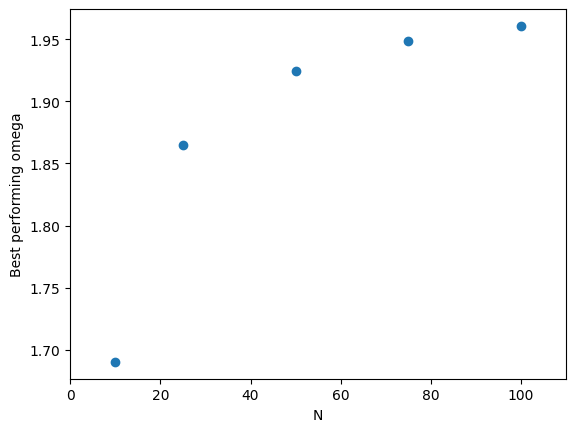

In [58]:
ax.set_xlabel('N')
ax.set_ylabel('Best performing omega')
ax.set_xlim([0, 110])
fig